# Notebook 04 — Machine Learning

Build and evaluate machine learning models to predict race points based on qualifying position, driver consistency, and constructor strength.

---

### Overview

| Aspect | Details |
|--------|--------|
| **Problem Type** | Regression (predicting continuous points 0-26) |
| **Target Variable** | `points` — race points scored |
| **Models** | Linear Regression, Decision Tree Regressor |
| **Split Strategy** | Time-based (Train: 2018-2022, Test: 2023-2024) |
| **Evaluation Metrics** | R², MSE (as required by professor) |

---

### Why Time-Based Split?

**time-based split** is used instead of random split to:
1. **Prevent data leakage** — Never train on future data
2. **Mimic real forecasting** — Train on past seasons, predict upcoming races
3. **Realistic evaluation** — Test how well model generalizes to NEW seasons

### Table of Contents

1. [Setup & Imports](#1-setup)
2. [Load Data](#2-load-data)
3. [Why Regression?](#3-why-regression)
4. [Feature Selection](#4-feature-selection)
5. [Train/Test Split](#5-split)
6. [Build Preprocessor & Models](#6-build-models)
7. [Train & Evaluate](#7-train-evaluate)
8. [Tune Decision Tree](#8-tune-dt)
9. [Results Visualization](#9-visualization)
10. [Feature Importance](#10-feature-importance)
11. [Conclusions](#11-conclusions)

---

## 1. Setup & Imports <a id='1-setup'></a>

In [1]:
import sys
from pathlib import Path

#data manipulation
import numpy as np
import pandas as pd

#visualization
import matplotlib.pyplot as plt

#scikit-learn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score


PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "src").exists() and (PROJECT_ROOT.parent / "src").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

sys.path.insert(0, str(PROJECT_ROOT))

#Import custom ML functions
from src.models import (
    build_preprocessor,
    time_based_split,
)

#Create directories
REPORT_DIR = PROJECT_ROOT / "reports"
FIG_DIR = REPORT_DIR / "figures"
REPORT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

#Display settings
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 200)

print("Setup complete!")
print(f"   Project root: {PROJECT_ROOT}")
print(f"   Reports dir:  {REPORT_DIR}")
print(f"   Figures dir:  {FIG_DIR}")

Setup complete!
   Project root: C:\Users\vbetlemidze\Desktop\SMOOTH-OPERATOR
   Reports dir:  C:\Users\vbetlemidze\Desktop\SMOOTH-OPERATOR\reports
   Figures dir:  C:\Users\vbetlemidze\Desktop\SMOOTH-OPERATOR\reports\figures


---

## 2. Load Data <a id='2-load-data'></a>

Load the preprocessed dataset created in Notebook 02.

In [2]:
#find processed data file
CANDIDATES = [
    PROJECT_ROOT / "data" / "processed" / "processed_f1_2018_2024.csv",
    PROJECT_ROOT / "data" / "processed" / "f1_clean_2018_2024.csv",
    PROJECT_ROOT / "data" / "processed" / "processed_f1.csv",
]

DATA_PATH = next((p for p in CANDIDATES if p.exists()), None)
if DATA_PATH is None:
    raise FileNotFoundError(
        "Could not find processed CSV. Checked:\n" + "\n".join(str(p) for p in CANDIDATES)
    )

#Load data
df = pd.read_csv(DATA_PATH)

print(f"Data loaded from: {DATA_PATH.name}")
print(f"   Shape: {df.shape[0]:,} rows x {df.shape[1]} columns")
print(f"   Years: {int(df['year'].min())} - {int(df['year'].max())}")

Data loaded from: processed_f1_2018_2024.csv
   Shape: 2,979 rows x 25 columns
   Years: 2018 - 2024


In [3]:
#Preview the data
df.head()

,raceId,year,round,name,date,driverId,driverName,nationality,constructorId,constructorName,grid,grid_clean,positionOrder,points,position_gain,is_podium,is_finished,is_dnf,is_dns,driver_races_past,driver_avg_points_past,driver_consistency_past,constructor_races_past,constructor_strength_past,constructor_avg_finish_past
0,989,2018,1,Australian Grand Prix,2018-03-25,20,Sebastian Vettel,German,6,Ferrari,3,3.0,1,25.0,2.0,1,1,0,0,0,0.0,4.574576,0,0.0,11.125
1,989,2018,1,Australian Grand Prix,2018-03-25,1,Lewis Hamilton,British,131,Mercedes,1,1.0,2,18.0,-1.0,1,1,0,0,0,0.0,4.574576,0,0.0,11.125
2,989,2018,1,Australian Grand Prix,2018-03-25,8,Kimi Räikkönen,Finnish,6,Ferrari,2,2.0,3,15.0,-1.0,1,1,0,0,0,0.0,4.574576,0,0.0,11.125
3,989,2018,1,Australian Grand Prix,2018-03-25,817,Daniel Ricciardo,Australian,9,Red Bull,8,8.0,4,12.0,4.0,0,1,0,0,0,0.0,4.574576,0,0.0,11.125
4,989,2018,1,Australian Grand Prix,2018-03-25,4,Fernando Alonso,Spanish,1,McLaren,10,10.0,5,10.0,5.0,0,1,0,0,0,0.0,4.574576,0,0.0,11.125


---

## 3. Why Regression? <a id='3-why-regression'></a>

Before building models, we need to understand **why we chose Regression** instead of Classification or Clustering.

### Our Target Variable

We want to predict: **`points`** — the number of points a driver scores in a race.

In [4]:
#Look at our target variable
print("TARGET VARIABLE: points")
print("=" * 50)
print(f"Data type: {df['points'].dtype}")
print(f"Unique values: {sorted(df['points'].unique())}")
print(f"Min: {df['points'].min()}, Max: {df['points'].max()}")
print(f"Mean: {df['points'].mean():.2f}")

TARGET VARIABLE: points
Data type: float64
Unique values: [np.float64(0.0), np.float64(0.5), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(7.5), np.float64(8.0), np.float64(9.0), np.float64(10.0), np.float64(11.0), np.float64(12.0), np.float64(12.5), np.float64(13.0), np.float64(15.0), np.float64(16.0), np.float64(18.0), np.float64(19.0), np.float64(25.0), np.float64(26.0)]
Min: 0.0, Max: 26.0
Mean: 5.07


### Three Types of ML Problems

| Problem Type | What You Predict | Example Question | Models |
|--------------|------------------|------------------|--------|
| **Regression** | A continuous NUMBER | "How many points will driver score?" | Linear Regression, Decision Tree Regressor |
| **Classification** | A CATEGORY/CLASS | "Will driver win? (Yes/No)" | Logistic Regression, Decision Tree Classifier |
| **Clustering** | GROUPS (no target) | "Which drivers are similar?" | K-Means, DBSCAN |

### Our Choice: REGRESSION

**Why?**

Our target `points` is a **continuous numerical value**: 0, 1, 2, 4, 6, 8, 10, 12, 15, 18, 25, 26

- We are predicting a **NUMBER**, not a category
- We want to know **how many** points, not just "points or no points"
- The prediction can be any value in a range

**If we wanted Classification, we would ask:**
- "Will driver finish on podium?" (Yes/No) → Binary Classification
- "Will driver finish P1, P2-3, P4-10, or P11+?" → Multi-class Classification

**If we wanted Clustering, we would ask:**
- "Which drivers have similar performance patterns?" → No target variable

### Models We Will Use (as covered in class)

For Regression problems, professor taught us to use:
1. **Linear Regression** — Assumes linear relationship between features and target
2. **Decision Tree Regressor** — Can capture non-linear patterns

---

## 4. Feature Selection <a id='4-feature-selection'></a>

We select features that can help predict race points:

| Feature | Type | Description | Why It Might Help |
|---------|------|-------------|-------------------|
| `grid_clean` | Numeric | Qualifying position | Better qualifying = more points |
| `driver_avg_points_past` | Numeric | Driver's historical avg points | Good drivers score more |
| `driver_consistency_past` | Numeric | Std dev of driver's past finishes | Consistent drivers are reliable |
| `driver_races_past` | Numeric | Driver experience (race count) | Experience might help |
| `constructor_strength_past` | Numeric | Team's historical avg points | Good car = more points |
| `constructor_races_past` | Numeric | Team experience | Established teams perform better |
| `constructorName` | Categorical | Team name | Team-specific effects |

**Target:** `points` (0-26)

In [5]:
# Define features
NUMERIC_FEATURES = [
    "grid_clean",                  # Qualifying position
    "driver_avg_points_past",      # Driver historical performance
    "driver_consistency_past",     # Driver reliability (std of finishes)
    "driver_races_past",           # Driver experience
    "constructor_strength_past",   # Team historical performance
    "constructor_races_past",      # Team experience
]

CATEGORICAL_FEATURES = [
    "constructorName",             # Team name (will be one-hot encoded)
]

TARGET = "points"

# Combine all features
ALL_FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES

print("Feature Selection:")
print(f"   Numeric features:     {len(NUMERIC_FEATURES)}")
print(f"   Categorical features: {len(CATEGORICAL_FEATURES)}")
print(f"   Target variable:      {TARGET}")

Feature Selection:
   Numeric features:     6
   Categorical features: 1
   Target variable:      points


In [6]:
# Create modeling dataframe with selected features + target + year (for splitting)
required_cols = ALL_FEATURES + [TARGET, "year"]
df_model = df[required_cols].copy()

print(f"Modeling dataframe shape: {df_model.shape}")
df_model.head()

Modeling dataframe shape: (2979, 9)


,grid_clean,driver_avg_points_past,driver_consistency_past,driver_races_past,constructor_strength_past,constructor_races_past,constructorName,points,year
0,3.0,0.0,4.574576,0,0.0,0,Ferrari,25.0,2018
1,1.0,0.0,4.574576,0,0.0,0,Mercedes,18.0,2018
2,2.0,0.0,4.574576,0,0.0,0,Ferrari,15.0,2018
3,8.0,0.0,4.574576,0,0.0,0,Red Bull,12.0,2018
4,10.0,0.0,4.574576,0,0.0,0,McLaren,10.0,2018


---

## 5. Train/Test Split <a id='5-split'></a>

We use **time-based split**:
- **Training:** 2018-2022 (5 seasons)
- **Testing:** 2023-2024 (2 seasons)

This is better than random split because it simulates real-world prediction (using past to predict future).

In [7]:
# Time-based split
X_train, X_test, y_train, y_test = time_based_split(
    df_model,
    feature_cols=ALL_FEATURES,
    target_col=TARGET,
    year_col="year",
    train_years=(2018, 2022),
    test_years=(2023, 2024),
)

print("Train/Test Split (Time-Based):")
print(f"   Training set: {len(X_train):,} rows (2018-2022)")
print(f"   Test set:     {len(X_test):,} rows (2023-2024)")
print(f"   Split ratio:  {len(X_train)/(len(X_train)+len(X_test))*100:.1f}% / {len(X_test)/(len(X_train)+len(X_test))*100:.1f}%")

Train/Test Split (Time-Based):
   Training set: 2,019 rows (2018-2022)
   Test set:     890 rows (2023-2024)
   Split ratio:  69.4% / 30.6%


---

## 6. Build Preprocessor & Models <a id='6-build-models'></a>

### Preprocessing Pipeline

| Feature Type | Preprocessing Steps |
|--------------|--------------------|
| Numeric | Fill missing with median |
| Categorical | Fill missing with most frequent, then One-Hot Encode |

In [8]:
# Build preprocessor
preprocessor = build_preprocessor(NUMERIC_FEATURES, CATEGORICAL_FEATURES)

print("Preprocessor built!")
print("   - Numeric: MedianImputer")
print("   - Categorical: MostFrequentImputer + OneHotEncoder")

Preprocessor built!
   - Numeric: MedianImputer
   - Categorical: MostFrequentImputer + OneHotEncoder


In [9]:
# Build models as pipelines
models = {
    "LinearRegression": Pipeline([
        ("preprocess", preprocessor),
        ("model", LinearRegression()),
    ]),
    "DecisionTree": Pipeline([
        ("preprocess", preprocessor),
        ("model", DecisionTreeRegressor(random_state=42, max_depth=8)),
    ]),
}

print("Models created:")
for name in models:
    print(f"   - {name}")

Models created:
   - LinearRegression
   - DecisionTree


---

## 7. Train & Evaluate <a id='7-train-evaluate'></a>

Train both models and evaluate using:
- **R² (R-squared)** — How much variance is explained (higher is better, max 1.0)
- **MSE (Mean Squared Error)** — Average squared error (lower is better)

In [10]:
# Train and evaluate each model
results = []
predictions = {}

for name, pipeline in models.items():
    print(f"Training {name}...")
    
    # Train
    pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred = pipeline.predict(X_test)
    predictions[name] = y_pred
    
    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    results.append({
        "Model": name,
        "R2": r2,
        "MSE": mse,
        "RMSE": rmse,
    })
    
    print(f"   R² = {r2:.4f}, MSE = {mse:.2f}")

print("\nTraining complete!")

Training LinearRegression...
   R² = 0.5153, MSE = 25.81
Training DecisionTree...
   R² = 0.4166, MSE = 31.07

Training complete!


In [11]:
# Results table
results_df = pd.DataFrame(results).sort_values("R2", ascending=False)

print("MODEL COMPARISON")
print("=" * 60)
display(results_df)

MODEL COMPARISON


,Model,R2,MSE,RMSE
0,LinearRegression,0.515296,25.814055,5.080753
1,DecisionTree,0.416555,31.072743,5.574293


---

## 8. Tune Decision Tree <a id='8-tune-dt'></a>

The Decision Tree might not be performing well with `max_depth=8`. Let's try different values to find the best one.

In [12]:
# Try different max_depth values
depth_results = []

for depth in [3, 5, 8, 10, 15, None]:  # None = unlimited depth
    # Build model with this depth
    dt_pipeline = Pipeline([
        ("preprocess", build_preprocessor(NUMERIC_FEATURES, CATEGORICAL_FEATURES)),
        ("model", DecisionTreeRegressor(random_state=42, max_depth=depth)),
    ])
    
    # Train and evaluate
    dt_pipeline.fit(X_train, y_train)
    y_pred = dt_pipeline.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    depth_results.append({
        "max_depth": str(depth) if depth else "None (unlimited)",
        "R2": r2,
        "MSE": mse,
    })

depth_df = pd.DataFrame(depth_results).sort_values("R2", ascending=False)

print("DECISION TREE TUNING - Different max_depth values")
print("=" * 60)
display(depth_df)

DECISION TREE TUNING - Different max_depth values


,max_depth,R2,MSE
0,3,0.564698,23.183018
1,5,0.502122,26.515696
2,8,0.416555,31.072743
3,10,0.352443,34.487167
4,15,0.276218,38.546729
5,None (unlimited),0.169604,44.224719


In [13]:
# Find best depth
best_depth_row = depth_df.iloc[0]
print(f"Best max_depth: {best_depth_row['max_depth']}")
print(f"Best R²: {best_depth_row['R2']:.4f}")
print(f"Best MSE: {best_depth_row['MSE']:.2f}")

Best max_depth: 3
Best R²: 0.5647
Best MSE: 23.18


In [14]:
# Retrain with best depth and update results
best_depth_value = depth_df.iloc[0]['max_depth']
if best_depth_value == "None (unlimited)":
    best_depth_int = None
else:
    best_depth_int = int(best_depth_value)

# Rebuild Decision Tree with best depth
models["DecisionTree"] = Pipeline([
    ("preprocess", build_preprocessor(NUMERIC_FEATURES, CATEGORICAL_FEATURES)),
    ("model", DecisionTreeRegressor(random_state=42, max_depth=best_depth_int)),
])

models["DecisionTree"].fit(X_train, y_train)
predictions["DecisionTree"] = models["DecisionTree"].predict(X_test)

# Update results
dt_r2 = r2_score(y_test, predictions["DecisionTree"])
dt_mse = mean_squared_error(y_test, predictions["DecisionTree"])

print(f"Decision Tree retrained with max_depth={best_depth_int}")
print(f"   New R² = {dt_r2:.4f}")
print(f"   New MSE = {dt_mse:.2f}")

Decision Tree retrained with max_depth=3
   New R² = 0.5647
   New MSE = 23.18


In [15]:
# Final comparison after tuning
final_results = []

for name, pipeline in models.items():
    y_pred = predictions[name]
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    final_results.append({
        "Model": name,
        "R2": r2,
        "MSE": mse,
        "RMSE": rmse,
    })

final_results_df = pd.DataFrame(final_results).sort_values("R2", ascending=False)

print("FINAL MODEL COMPARISON (after tuning)")
print("=" * 60)
display(final_results_df)

# Determine winner
best_model = final_results_df.iloc[0]['Model']
best_r2 = final_results_df.iloc[0]['R2']
best_mse = final_results_df.iloc[0]['MSE']

print(f"\nWINNER: {best_model}")
print(f"   R² = {best_r2:.4f} ({best_r2*100:.1f}% variance explained)")
print(f"   MSE = {best_mse:.2f}")

FINAL MODEL COMPARISON (after tuning)


,Model,R2,MSE,RMSE
1,DecisionTree,0.564698,23.183018,4.814875
0,LinearRegression,0.515296,25.814055,5.080753



WINNER: DecisionTree
   R² = 0.5647 (56.5% variance explained)
   MSE = 23.18


In [16]:
# Save results to CSV
results_csv_path = REPORT_DIR / "model_results.csv"
final_results_df.to_csv(results_csv_path, index=False)
print(f"Results saved to: {results_csv_path}")

Results saved to: C:\Users\vbetlemidze\Desktop\SMOOTH-OPERATOR\reports\model_results.csv


---

## 9. Results Visualization <a id='9-visualization'></a>

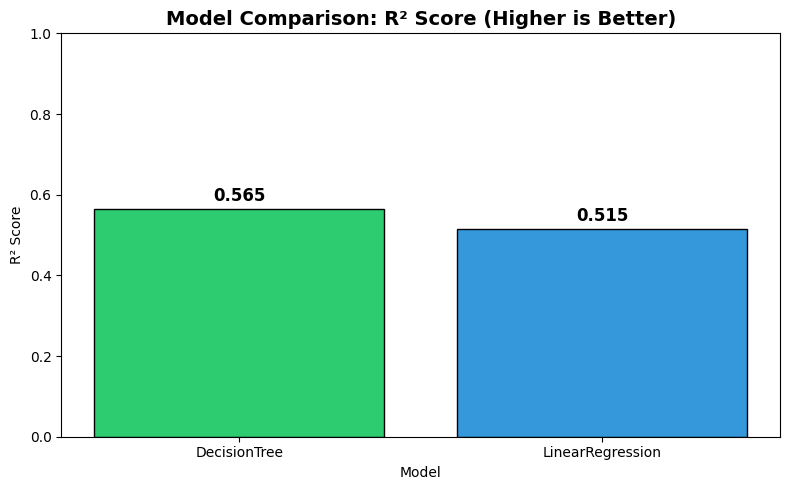

Saved: C:\Users\vbetlemidze\Desktop\SMOOTH-OPERATOR\reports\figures\ml_model_r2_comparison.png


In [17]:
# R² Comparison
fig, ax = plt.subplots(figsize=(8, 5))

colors = ['#2ecc71' if m == best_model else '#3498db' for m in final_results_df['Model']]
bars = ax.bar(final_results_df['Model'], final_results_df['R2'], color=colors, edgecolor='black')

ax.set_title('Model Comparison: R² Score (Higher is Better)', fontsize=14, fontweight='bold')
ax.set_xlabel('Model')
ax.set_ylabel('R² Score')
ax.set_ylim(0, 1)

# Add value labels
for bar, val in zip(bars, final_results_df['R2']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{val:.3f}', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(FIG_DIR / "ml_model_r2_comparison.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {FIG_DIR / 'ml_model_r2_comparison.png'}")

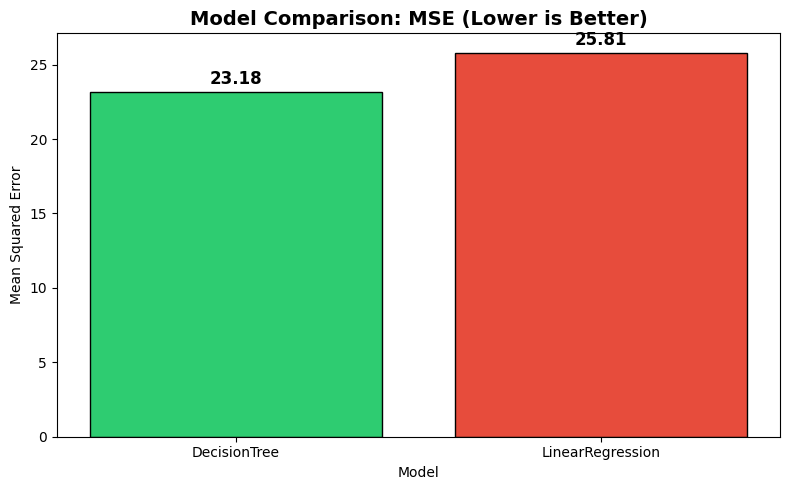

Saved: C:\Users\vbetlemidze\Desktop\SMOOTH-OPERATOR\reports\figures\ml_model_mse_comparison.png


In [18]:
# MSE Comparison
fig, ax = plt.subplots(figsize=(8, 5))

colors = ['#2ecc71' if m == best_model else '#e74c3c' for m in final_results_df['Model']]
bars = ax.bar(final_results_df['Model'], final_results_df['MSE'], color=colors, edgecolor='black')

ax.set_title('Model Comparison: MSE (Lower is Better)', fontsize=14, fontweight='bold')
ax.set_xlabel('Model')
ax.set_ylabel('Mean Squared Error')

# Add value labels
for bar, val in zip(bars, final_results_df['MSE']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f'{val:.2f}', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(FIG_DIR / "ml_model_mse_comparison.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {FIG_DIR / 'ml_model_mse_comparison.png'}")

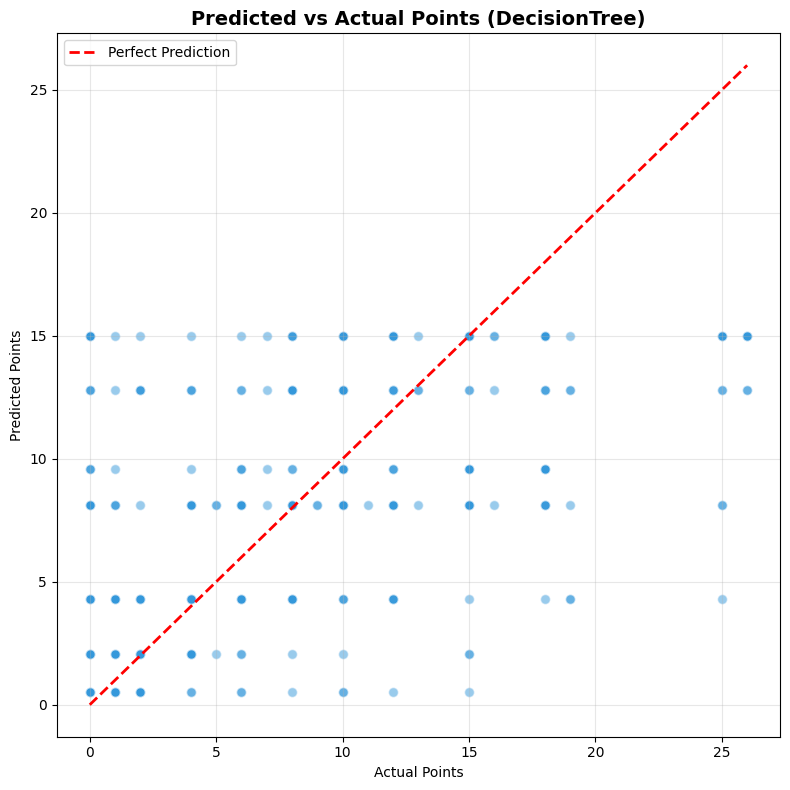

Saved: C:\Users\vbetlemidze\Desktop\SMOOTH-OPERATOR\reports\figures\ml_predicted_vs_actual.png


In [19]:
# Predicted vs Actual for best model
fig, ax = plt.subplots(figsize=(8, 8))

y_pred_best = predictions[best_model]

ax.scatter(y_test, y_pred_best, alpha=0.5, color='#3498db', edgecolors='white', s=50)

# Perfect prediction line
max_val = max(y_test.max(), y_pred_best.max())
ax.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')

ax.set_title(f'Predicted vs Actual Points ({best_model})', fontsize=14, fontweight='bold')
ax.set_xlabel('Actual Points')
ax.set_ylabel('Predicted Points')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / "ml_predicted_vs_actual.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {FIG_DIR / 'ml_predicted_vs_actual.png'}")

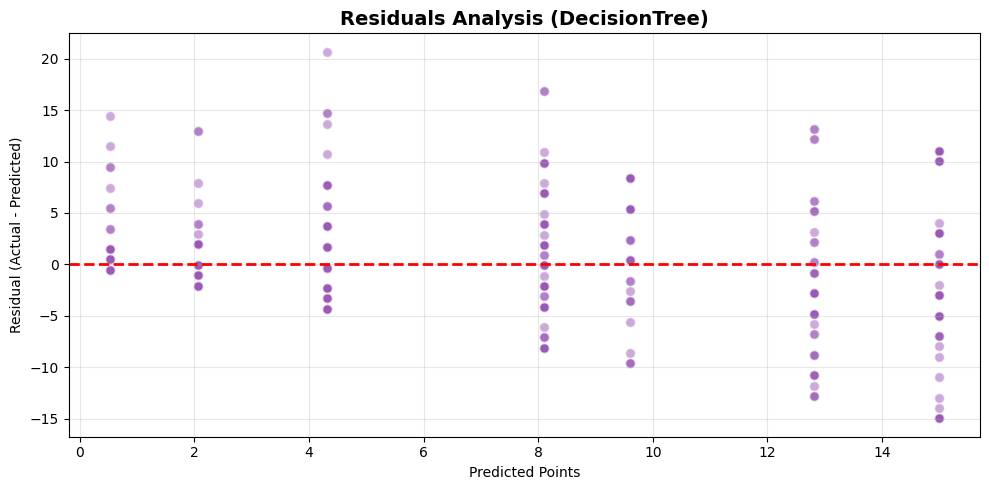

Saved: C:\Users\vbetlemidze\Desktop\SMOOTH-OPERATOR\reports\figures\ml_residuals_analysis.png


In [20]:
# Residuals plot
fig, ax = plt.subplots(figsize=(10, 5))

residuals = y_test.values - y_pred_best

ax.scatter(y_pred_best, residuals, alpha=0.5, color='#9b59b6', edgecolors='white', s=50)
ax.axhline(y=0, color='red', linestyle='--', linewidth=2)

ax.set_title(f'Residuals Analysis ({best_model})', fontsize=14, fontweight='bold')
ax.set_xlabel('Predicted Points')
ax.set_ylabel('Residual (Actual - Predicted)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / "ml_residuals_analysis.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {FIG_DIR / 'ml_residuals_analysis.png'}")

---

## 10. Feature Importance <a id='10-feature-importance'></a>

Decision Tree can tell us which features are most important for prediction.

In [21]:
# Get feature names after preprocessing
dt_model = models["DecisionTree"]
preprocessor_fitted = dt_model.named_steps['preprocess']

# Get feature names
num_features = NUMERIC_FEATURES
cat_features = list(preprocessor_fitted.named_transformers_['cat']
                   .named_steps['onehot']
                   .get_feature_names_out(CATEGORICAL_FEATURES))

all_feature_names = num_features + cat_features

# Get importances
importances = dt_model.named_steps['model'].feature_importances_

# Create dataframe
importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("Feature Importances (Decision Tree):")
display(importance_df.head(10))

Feature Importances (Decision Tree):


,feature,importance
4,constructor_strength_past,0.734572
0,grid_clean,0.225808
1,driver_avg_points_past,0.039620
2,driver_consistency_past,0.000000
3,driver_races_past,0.000000
5,constructor_races_past,0.000000
6,constructorName_Alfa Romeo,0.000000
7,constructorName_AlphaTauri,0.000000
8,constructorName_Alpine F1 Team,0.000000
9,constructorName_Aston Martin,0.000000


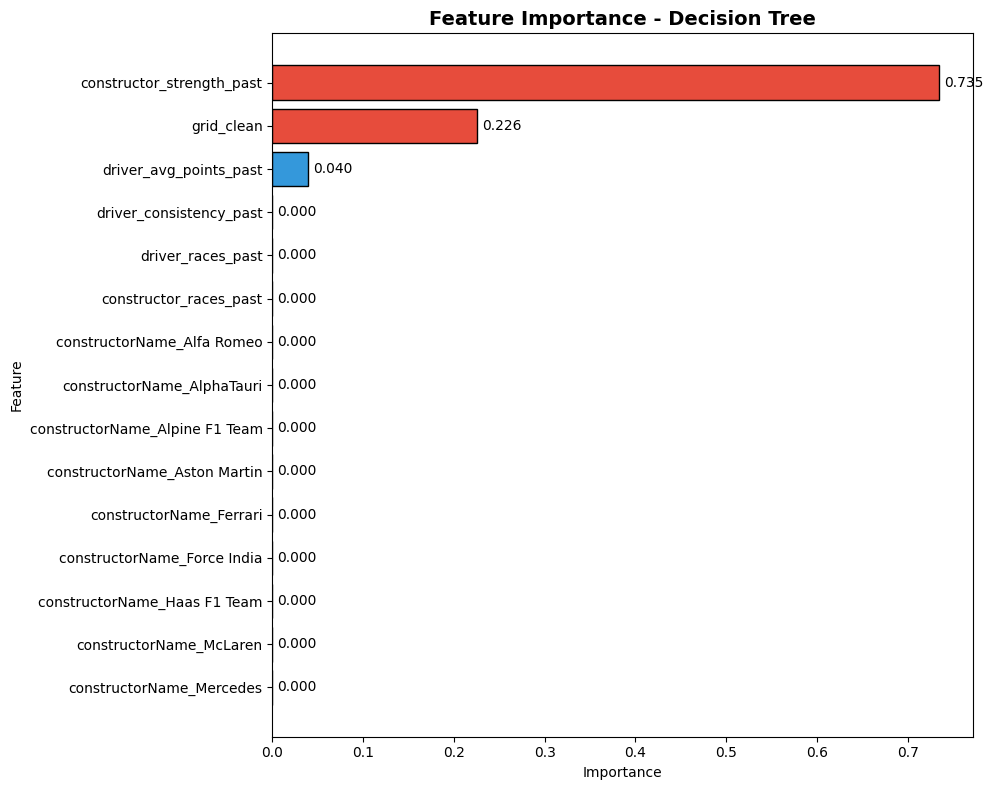

Saved: C:\Users\vbetlemidze\Desktop\SMOOTH-OPERATOR\reports\figures\ml_feature_importance.png


In [22]:
# Plot feature importance (top 15)
top_n = 15
top_features = importance_df.head(top_n)

fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#e74c3c' if imp > 0.1 else '#3498db' for imp in top_features['importance']]

bars = ax.barh(range(len(top_features)), top_features['importance'], color=colors, edgecolor='black')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.invert_yaxis()  # Highest at top

ax.set_title('Feature Importance - Decision Tree', fontsize=14, fontweight='bold')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')

# Add value labels
for i, (bar, imp) in enumerate(zip(bars, top_features['importance'])):
    ax.text(imp + 0.005, i, f'{imp:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig(FIG_DIR / "ml_feature_importance.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {FIG_DIR / 'ml_feature_importance.png'}")

---

## 11. Conclusions <a id='11-conclusions'></a>

In [23]:

print("=" * 70)
print("MACHINE LEARNING RESULTS SUMMARY")
print("=" * 70)
print()
print("PROBLEM TYPE: Regression")
print("   - Target: points (continuous numerical value 0-26)")
print("   - Why Regression? We predict a NUMBER, not a category")
print()
print("DATASET:")
print(f"   Total records:     {len(df_model):,}")
print(f"   Training set:      {len(X_train):,} (2018-2022)")
print(f"   Test set:          {len(X_test):,} (2023-2024)")
print(f"   Features used:     {len(ALL_FEATURES)} ({len(NUMERIC_FEATURES)} numeric, {len(CATEGORICAL_FEATURES)} categorical)")
print()
print("MODEL COMPARISON:")
print("-" * 70)
print(f"{'Model':<25} {'R²':>10} {'MSE':>10}")
print("-" * 70)
for _, row in final_results_df.iterrows():
    marker = " <-- WINNER" if row['Model'] == best_model else ""
    print(f"{row['Model']:<25} {row['R2']:>10.4f} {row['MSE']:>10.2f}{marker}")
print("-" * 70)
print()
print(f"WINNER: {best_model}")
print(f"   - R² = {best_r2:.4f} (explains {best_r2*100:.1f}% of variance)")
print(f"   - MSE = {best_mse:.2f}")
print()
print("=" * 70)

MACHINE LEARNING RESULTS SUMMARY

PROBLEM TYPE: Regression
   - Target: points (continuous numerical value 0-26)
   - Why Regression? We predict a NUMBER, not a category

DATASET:
   Total records:     2,979
   Training set:      2,019 (2018-2022)
   Test set:          890 (2023-2024)
   Features used:     7 (6 numeric, 1 categorical)

MODEL COMPARISON:
----------------------------------------------------------------------
Model                             R²        MSE
----------------------------------------------------------------------
DecisionTree                  0.5647      23.18 <-- WINNER
LinearRegression              0.5153      25.81
----------------------------------------------------------------------

WINNER: DecisionTree
   - R² = 0.5647 (explains 56.5% of variance)
   - MSE = 23.18



In [24]:
#list generated files
print("Generated Files:")
print()
print("Results:")
print(f"   - {results_csv_path}")
print()
print("Visualizations:")
for fig_file in sorted(FIG_DIR.glob("ml_*.png")):
    print(f"   - {fig_file.name}")

Generated Files:

Results:
   - C:\Users\vbetlemidze\Desktop\SMOOTH-OPERATOR\reports\model_results.csv

Visualizations:
   - ml_feature_importance.png
   - ml_model_mse_comparison.png
   - ml_model_r2_comparison.png
   - ml_predicted_vs_actual.png
   - ml_residuals_analysis.png
